# Diffusion Model Output Analysis

Small notebook to try and play with the outputs from a diffusion model, and see if we can find any patterns!

## Load Data

In [76]:
import os
import re
import json

import torch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [77]:
# current options are either 10 or 40 samples
n = 200
outputs_file = f'out_gen/diff_e2e-tgt_block_{n}_samples.json'
tensors_file = f'out_gen/diff_e2e-tgt_block_{n}_samples_tensors.pt'

with open(outputs_file) as fin:
    output_data = json.load(fin)

tensor_data = torch.load(tensors_file)

In [78]:
tensor_key = list(tensor_data.keys())[0]
output_key = list(output_data.keys())[0]
tensor_key == output_key

True

In [79]:
tensor_values = tensor_data[tensor_key]
tensor_values.shape

torch.Size([12864, 64, 16])

In [80]:
output_values = output_data[output_key]
len(output_values)

12864

In [81]:
def load_index(i, output_values=output_values, tensor_values=tensor_values):
    outputs = [v for j, v in enumerate(output_values) if j % 64 == i]
    tensors = tensor_values[[j for j in range(tensor_values.size(0)) if j % 64 == i]]
    return outputs, tensors

## Output Visualization

In [82]:
sequence, tensors = load_index(2)
for s in sequence:
    print('----------------------------------------------')
    print(s)

----------------------------------------------
Don Clowns are costly star five out START eat UNK Aromi kid The Waterman Indian food food sells a , The Holiday it 5 is Rouge hotel food family END given eats £ START Fitzbillies English service Indian low . 5 , in score a only START is Brazil from more Good Tree Clowns kid with Cocum service Bells fast is Cocum location There
----------------------------------------------
UNK START price , well coffee high pub typical at area The is food Italian Blue serves UNK drink over food average The Aromi cheap UNK Boat a of rating price , in restaurant 5 . at END customers a kid child serving Strada food START than and every a are star Fitzbillies . food has our service . provides the is is is
----------------------------------------------
Indian pub . , well atmosphere food rating is at new and 20 . price can the of Indian 25 food are The UNK cheap . drink the There food welcomed The . restaurant high . at in range a price riverside serving on foo

In [83]:
import re

def get_output_progression(i, gen_index=1):
    sequence, _ = load_index(i)
    gen_outputs = []
    for line in sequence:
        output = re.split('START|END', line)
        cleaned_output = [o for o in output if len(o.strip().split()) > 0]
        gen_outputs.append(cleaned_output[gen_index])
    return gen_outputs

gen_outputs = get_output_progression(2, gen_index=0)
for output in gen_outputs:
    print()
    print(output)


Don Clowns are costly star five out 

UNK 

Indian pub . , well atmosphere food rating is at new and 20 . price can the of Indian 25 food are The UNK cheap . drink the There food welcomed The . restaurant high . at in range a price riverside serving on food The the and Chinese . coffee star a The friendly a There Japanese UNK provides the serves price The

Indian a the friendly wine coffee food UNK is food under and food . restaurant can the budget Indian slightly friendly are The UNK customer . average the Golden a he The the . 5 . Golden in are friendly price riverside at The average The the . Chinese UNK coffee star a atmosphere . customer is its UNK provides average 5 , Strada

Indian a the , Chinese coffee food friendly kid food food price food friendly is can by of Indian centre the are The UNK star . are the Golden a are offers the . 5 Waterman food families price friendly near high and the Waterman The are and Strada UNK are star a The the , is rate Strada have average 5 is St

## Distance to Output

In [84]:
outputs, tensors = load_index(2)

final_output, final_tensor = outputs[-1], tensors[-1]

print(final_output)

priced pub near the Café Adriatic with a cheap 5 star rating , try The Vaults 
 END START Rated 5 out of 5 , The Golden Palace coffee shop offers Italian food and is located in the city centre . 
 END START North of the City centre is a 5 star restaurant called The Phoenix . 
 END START The Golden Curry


In [85]:
parsed_sentence = re.split('START|END|\n', final_output)[0]
print(parsed_sentence)

priced pub near the Café Adriatic with a cheap 5 star rating , try The Vaults 


In [86]:
length = len(parsed_sentence.split())
print(length)
sentence_tensors = tensors[:, :length, :]

16


In [87]:
final_tensor = final_tensor[:length, :]
final_tensor.shape

torch.Size([16, 16])

In [88]:
distances = (sentence_tensors - final_tensor).norm(dim=-1)

In [89]:
import pandas as pd

data = pd.DataFrame(data=distances.numpy(), columns=parsed_sentence.split())
data.head()

,priced,pub,near,the,Café,Adriatic,with,a,cheap,5,star,rating,",",try,The,Vaults
0,6.568522,6.351520,5.033824,4.737360,5.904862,4.225908,4.871663,4.285038,4.908807,5.441838,5.240983,5.955737,5.162085,4.347402,4.305799,4.846970
1,5.158073,4.078768,6.288372,3.211199,5.035739,5.774449,3.955007,3.519412,5.473299,5.789361,5.729047,3.324755,4.583817,3.596038,4.061322,6.778745
2,5.516316,3.282159,5.293087,3.158767,4.853034,5.510473,3.950364,3.917113,5.170553,5.256853,5.786819,4.713968,4.334124,3.721763,4.296418,5.831504
3,5.315528,3.976716,4.762904,3.698973,4.433117,5.975455,3.821494,4.106307,4.279488,4.528516,5.584603,4.979434,4.449160,4.045417,4.261642,5.231551
4,5.126781,3.970731,4.214491,3.633120,4.365981,5.766965,3.812835,3.782535,4.335167,4.008781,5.209185,4.980960,3.975651,5.118642,3.936746,4.994500


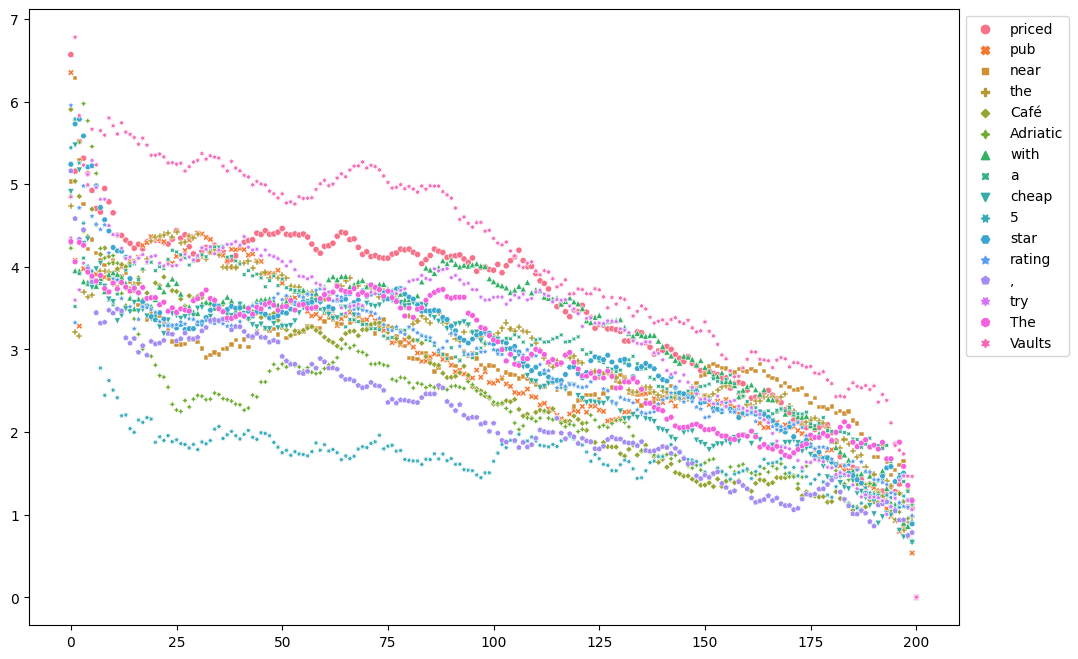

In [90]:
fig = plt.gcf()

fig.set_size_inches(12, 8)

ax = sns.scatterplot(data=data, s=20)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## Load Vocabulary and Embedding Matrix

In [91]:
models_dir = '../../../../improved-diffusion/diffusion_models/'
model_name = 'diff_e2e-tgt_block_rand16_transformer_lr0.0001_0.0_2000_sqrt_Lsimple_h128_s2_d0.1_sd102_xstart_e2e'

vocabulary_filename = os.path.join(models_dir, model_name, 'vocab.json')

In [92]:
with open(vocabulary_filename) as f:
    vocabulary = json.load(f)

# tokenizer is inverse of vocabulary dictionary
tokenizer = {v : k for k, v in vocabulary.items()}
len(tokenizer)

821

In [93]:
embedding = torch.load('trained_embedding.pt')
embedding

Linear(in_features=16, out_features=821, bias=True)

In [94]:
def decode_with_lm_head(x, embedding=embedding, tokenizer=tokenizer):
    scores = embedding(x)
    
    cands = torch.topk(scores, k=1, dim=-1)
    
    output = []
    for seq in cands.indices:
        tokens = " ".join([tokenizer[w[0].item()] for w in seq])
        output.append(tokens)
    return output

In [95]:
print(decode_with_lm_head(tensors[-1:])[0])

priced pub near the Café Adriatic with a cheap 5 star rating , try The Vaults 
 END START Rated 5 out of 5 , The Golden Palace coffee shop offers Italian food and is located in the city centre . 
 END START North of the City centre is a 5 star restaurant called The Phoenix . 
 END START The Golden Curry
